#  决策树

## 九, 决策树

### 1, 概念理解

决策树: 通过数据特征的差别, 用已知数据训练将不同数据划分到不同分支(子树)中, 层层划分, 最终得到一个树型结构, 用来对未知数据进行预测,
实现分类或回归

例如, 有如下数据集, 预测第 11 条数据能否偿还债务:

序号 | 有无房产 | 婚姻状况 | 年收入 | 能否偿还债务  
---|---|---|---|---  
1 | 是 | 单身 | 125 | 能  
2 | 否 | 已婚 | 100 | 能  
3 | 否 | 单身 | 100 | 能  
4 | 是 | 已婚 | 110 | 能  
5 | 是 | 离婚 | 60 | 能  
6 | 否 | 离婚 | 95 | 不能  
7 | 否 | 单身 | 85 | 不能  
8 | 否 | 已婚 | 75 | 能  
9 | 否 | 单身 | 90 | 不能  
10 | 是 | 离婚 | 220 | 能  
11 | 否 | 已婚 | 94 | ?  

我们可以将已知样本作如下划分(训练), 构建一颗决策树, 然后将第 11 条数据代入(测试), 落在哪一个叶子中, 它就是对应叶子的类别: 预测结果是
**能**

![]()

上例中, 层级已经不可再分, 但如果只划分到婚姻状况就不再划分如何实现预测?

决策树实现预测:  
对于分类树, 叶子节点中, 哪个类别样本数量最多, 就将其作为未知样本的类别  
对于回归树, 使用叶子节点中, 所有样本的均值, 作为未知样本的结果

对于上例, 如果只划分到婚姻状况, 那对于婚姻状况这个叶子中, 不能偿还的最多, 预测结果就是 **不能**

### 2, 分类决策树

对上例出现的情况, 我们会有如下问题:  
我们为什么以年收入开始划分, 依据是什么? 划分顺序怎么定?  
年收入为什么选 97.5 为划分阈值?  
要划分多少层才好, 是否越多越好?  
等等…

下面一步步来作讨论:

#### 2.01, 信息熵

**信息熵** : 用来描述信源的不确定度, 不确定性越大, 信息熵越大. 例如, 明天海南要下雪, 不确定性非常小, 信息熵很小, 明天海南要下雨,
不确定性大, 信息熵就大

设随机变量 X 具有 m 个特征值, 各个值出现的概率为 $p_{1}$, …, $p_{m}$, 且

$$p_{1}+p_{2}+\cdots+p_{m} = 1$$

则变量 X 的信息熵(信息期望值)为:

$$H(X)=-p_{1} \log_{2} p_{1} -p_{2} \log_{2} p_{2}-\cdots -p_{m} \log_{2}
p_{m}$$

$$ =-\sum_{i=1}^{m}p_{i}\log_{2}p_{i}$$

#### 2.02, 概率分布与信息商的关系

假设明天下雨的概率从 0.01 ~ 0.99 递增, 那么不下雨的概率就从 0.99 ~ 0.01 递减, 看看概率分布和信息熵的关系:

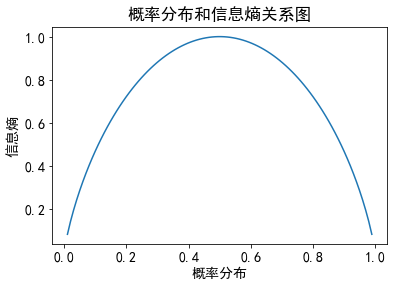

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  

plt.rcParams['font.family'] = 'SimHei'  
plt.rcParams['font.size'] = 14  

# 下雨的概率  
p = np.linspace(0.01, 0.99, 100)  

# 信息熵  
h = -p * np.log2(p) - (1-p) * np.log2(1-p)  

# 绘制关系图  
plt.plot(p, h)  
plt.xlabel('概率分布')  
plt.ylabel('信息熵')  
plt.title('概率分布和信息熵关系图')  
plt.show()  

可见, 概率分布越均衡, 不确定性越大, 信息熵越大, 在所有概率都相等(p下雨=p不下雨)时, 信息熵最大

如果把概率分布转换到决策树的数据集上, 信息熵体现的就是数据的 **不纯度** , 即样本类别的均衡程度. 因为数据集是未分类的, 要把它分类,
样本类别越均衡, 各个类别的占比(概率)分布越均衡, 不纯度越高, 信息熵越大

#### 2.03, 信息增益

信息增益的定义如下:

$$I G\left(D_{p}, f\right)=I\left(D_{p}\right)-\sum_{j=1}^{n}
\frac{N_{j}}{N_{p}} I\left(D_{j}\right) $$

$f$: 划分的特征  
$D_{p}$: 父节点, 即使用特征 f 分割之前的节点  
$I G\left(D_{p}, f\right)$: 父节点 $D_{p}$ 使用特征 f 划分下, 获得的信息增益  
$I\left(D_{p}\right)$：父节点不纯度, 信息熵是度量标准之一  
$D_{j}$: 父节点 $D_{p}$ 经过分割之后, 会产生 n 个子节点, $D_{j}$ 为第 j 个子节点  
$I\left(D_{j}\right)$：子节点不纯度  
$N_{p}$: 父节点 $D_{p}$ 包含样本的数量  
$N_{j}$: 第 j 个子节点 $D_{j}$ 包含样本的数量

如果是二叉树, 即父节点最多分为左右两个子节点, 此时, 信息增益为:

$$I G\left(D_{p}, f\right)=I\left(D_{p}\right)-\frac{N_{l e f t}}{N_{p}}
I\left(D_{l e f t}\right)-\frac{N_{r i g h t}}{N_{p}} I\left(D_{r i g h
t}\right)$$

可见, 信息增益就是父节点的不纯度减去所有子节点的(加权)不纯度

父节点的不纯度是不变的, 在选择特征进行类别划分时, 应该让子节点的不纯度尽可能低, 这样训练可以更快完成, 信息增益也最大. 这正是训练决策树时,
选择特征顺序的依据

以开头的例子为例, 不纯度使用信息熵度量, 则根节点的信息熵为:

$$I\left(D_{p}\right)=-0.7 * \log _{2} 0.7-0.3 * \log _{2} 0.3=0.88$$

如果以”有无房产”划分, 则可计算得子节点信息熵:

$$\begin{array}{l}  
I\left(D_{\text {有房产 }}\right)=0 \  
I\left(D_{\text {无房产 }}\right)=1  
\end{array}$$

从而可得根节点信息增益为:

$$I G(\text { 有无房产 })=0.88-0.4 * 0-0.6 * 1=0.28 $$

同理,

$$I G(\text { 婚姻状况 })=0.205 $$

而对于年收入, 将年收入排序后, 取不同类别的分界点年收入(75 与 85, 95 与 100)的均值进行划分, 比较哪一个信息增益大:

$$\begin{array}{l}  
I\left(D_{\text {年收入 }< 80}\right)=0 \  
I\left(D_{\text { 年收入 } >=80}\right)=0.954 \  
I G(\text { 年收入 }=80)=0.88-0.2 * 0-0.8 * 0.954=0.117  
\end{array}$$

同理,

$$I G(\text { 年收入 }=97.5)=0.395$$

可见, 以 年收入=97.5 划分时, 信息增益最大, 故首先选它进行划分

根节点划分结束, 第二层的父节点以同样的方式计算之后再次划分, 一直到划分停止

#### 2.04, 过拟合与欠拟合

如果不设置条件, 是不是划分深度越大越好呢?

下面以鸢尾花数据集为例, 看看划分深度对模型效果的影响:

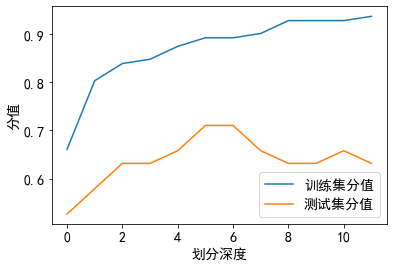

In [2]:
from sklearn.datasets import load_iris  
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeClassifier  

x, y = load_iris(return_X_y=True)  
x = x[:, :2]  
x_train, x_test, y_train, y_test = train_test_split(  
    x, y, test_size=0.25, random_state=0)  
'''  
参数介绍:  
criterion: 不纯度度量标准, 默认基尼系数 gini, 信息熵为 entropy  
splitter: 选择划分节点的方式, 默认最好 best, 随机 random  
max_depth: 划分深度, 默认 None 不设限  
min_samples_split: 划分节点的最小样本数, 默认 2  
min_samples_leaf: 划分节点后, 叶子节点的最少样本数, 默认 1  
max_features: 划分节点时, 考虑的最大特征数, 默认 None 考虑所有, 设置数量后会随机选择  
random_state: 随机种子, 控制模型的随机行为  
'''  
tree = DecisionTreeClassifier()  

# 定义列表, 用来储存不同深度下, 模型的分值  
train_score = []  
test_score = []  

# 设置深度 1~12 开始训练  
for depth in range(1, 13):  
    tree = DecisionTreeClassifier(criterion='entropy',  
                    max_depth=depth, random_state=0)  
    tree.fit(x_train, y_train) 

 

    train_score.append(tree.score(x_train, y_train))  
    test_score.append(tree.score(x_test, y_test))  

plt.plot(train_score, label='训练集分值')  
plt.plot(test_score, label='测试集分值')  
plt.xlabel('划分深度')  
plt.ylabel('分值')  
plt.legend()  
plt.show() 

可见, 划分深度小, 训练集和测试集的分值都小, 容易欠拟合  
随着划分深度的增加, 分值都在增加, 模型预测效果也在变好  
当深度增加到一定程度, 深度再增加, 训练集分值随着增加, 但造成了模型过分依赖训练集数据特征, 从而测试集分值减小, 容易过拟合

### 3, 不纯度度量标准

不纯度度量标准有:

**信息熵**

$$I_{H}(D)=-\sum_{i=1}^{m} p(i \mid D) \log _{2} p(i \mid D) $$

m: 节点 D 中含有样本的类别数量  
$p(i \mid D)$: 节点 D 中, 属于类别 i 的样本占节点 D 中样本总数的比例(概率)

**基尼系数**

$$I_{G}(D)=1-\sum_{i=1}^{m} p(i \mid D)^{2}$$

**错误率**

$$I_{E}(D)=1-\max {p(i \mid D)}$$

看看各个度量标准与概率分布的关系:

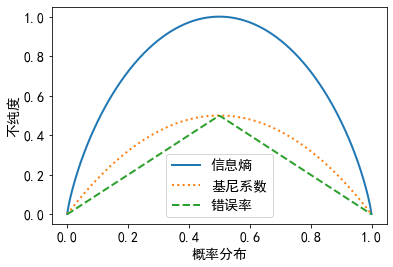

In [3]:
def entropy(p):  
    return -p * np.log2(p) - (1-p) * np.log2(1-p)  

def gini(p):  
    return 1 - p**2 - (1-p)**2  

def error(p):  
    return 1 - np.max([p, 1-p], axis=0)  

p = np.linspace(0.0001, 0.9999, 200)  

en = entropy(p)  
er = error(p)  
g = gini(p)  

for i, lab, ls in zip([en, g, er],  
                      ['信息熵', '基尼系数', '错误率'],  
                      ['-', ':', '--']):  
    plt.plot(p, i, label=lab, linestyle=ls, lw=2)  

plt.legend()  
plt.xlabel('概率分布')  
plt.ylabel('不纯度')  
plt.show()  

可见, 无论选哪一种度量标准, 样本属于同一类, 不纯度都是 0; 样本中不同类别占比相同时, 不纯度最大

### 4, 决策树常用算法介绍

**ID3**

ID3 (Iterative Dichotomiser3), 迭代二分法特点:  
-使用多叉树结构  
-使用信息熵作为不纯度度量, 选择信息增益最大的特征划分  
-经典算法, 简单, 训练快  
局限:  
-不支持连续特征  
-不支持缺失值处理  
-不支持回归  
-倾向选择特征取值多的特征来划分, 例如按身份证号划分, 一个号码就是一个特征

**C4.5**

ID3算法改进而来, 特点:  
-使用多叉树结构  
-不支持回归  
优化:  
-支持缺失值处理  
-连续值进行离散化处理  
-信息熵作为不纯度度量, 但选择 **信息增益率** 最大的特征划分 

信息增益率:

$$I G_{\text {Ratio}}\left(D_{p}, f\right)=\frac{I G_{H}\left(D_{p},
f\right)}{I_{H}(f)} $$

$I_{H}(f)$: 在特征 $f$ 下, 取各个特征值计算得到的信息熵之和, 其实就是特征 $f$ 的不纯度, 特征值越多, 特征不纯度越大

选择信息增益最大的特征来划分, 父节点的信息熵不变, 就要求信息增益的第二项 $\sum_{j=1}^{n} \frac{N_{j}}{N_{p}}
I\left(D_{j}\right)$ 最小, 从而会倾向选择特征取值多的特征

因为, 特征取值多, 通常划分之后子节点的不纯度(信息熵)就更低, 例如极端情况, 选身份证划分, 划分之后不管什么类别, 子节点都只有一种类别,
不纯度都是 0, 第二项就是 0, 信息增益就最大

因此, 采用信息增益率, 将 信息增益/特征不纯度, 就避免了 特征不纯度大 造成 信息增益大 而选择类别多的特征来划分的情况

看看类别数量与信息熵的关系:

In [4]:
en = lambda p: np.sum(-p * np.log2(p))  

a1 = np.array([0.3, 0.7])  
a2 = np.array([0.3, 0.3, 0.4])  
a3 = np.array([0.25] * 4)  
a4 = np.array([0.1] * 10)  

print(en(a1), en(a2), en(a3), en(a4), sep='\n')  

0.8812908992306927
1.5709505944546684
2.0
3.321928094887362


---|---  


0.8812908992306927
1.5709505944546684
2.0
3.321928094887362

**CART**

CART (Classification And Regression Tree), 分类回归树, 特点如下:  
-使用二叉树结构  
-支持连续值与缺失值处理  
-分类时, 使用基尼系数作为不纯度度量, 选择基尼增益最大的特征划分  
-回归时, 使用 MSE 或 MAE 最小的特征划分

### 5, 回归决策树

回归决策树因变量 y 是连续的, 使用叶子节点的均值来预测未知样本, 使用 MSE 或 MAE 作为特征划分的评估指标

在 scikit-learn 中, 使用的是优化的 CART 算法来实现决策树

以波士顿房价为例来实现(参数参考分类决策树):

In [5]:
from sklearn.datasets import load_boston  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import train_test_split  

x, y = load_boston(return_X_y=True)  
x_train, x_test, y_train, y_test = train_test_split(  
            x, y, test_size=0.25, random_state=1)  

tree = DecisionTreeRegressor(max_depth=5, random_state=0)  
tree.fit(x_train, y_train)  
print(tree.score(x_train, y_train))  
print(tree.score(x_test, y_test))  

0.9204825770764915
0.8763987309111113
